#Mount device#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/machine\ learning

/content/drive/MyDrive/machine learning


In [ ]:
!pwd

/content/drive/MyDrive/machine learning


#Import#

In [ ]:
from collections import Counter
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import tensorflow as tf

import nltk

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

#Define Constants#

In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
EMBEDDING_DIM = 300      # embedding dimensions for word vectors (GloVe/word2vec)
GLOVE_DIR = "glove.6B."+str(EMBEDDING_DIM)+"d.txt"

#Load Data#

In [ ]:
train = pd.read_csv('DATA/per_period/period_10.csv') # enter period of which you want to predict popularity of
y = train['pop_class'].values
lyrics_train = train['lyrics']
lyrics_train = list(lyrics_train)

labels = [0, 1]

In [ ]:
print(len(lyrics_train))

4126


In [ ]:
texts = [] 

for line in tqdm_notebook(lyrics_train, total=59): 
    if type(line) != float:
      texts.append(line)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/59 [00:00<?, ?it/s]

In [ ]:
print('Sample data:', texts[753], y[753])

Sample data: well know problem nobody saying anybody got problem could get poppin whatever got opinion give fuck think bitch wan na get get u good nigga wan na feel fuck wisha would think gon na hit getting shit think gon na hit getting shit bitch wan na get get u good nigga wan na feel fuck wisha would think gon na hit getting shit think gon na hit getting shit throw em muthafucka bitch blanco smooth cat new jack uciano around world stacking paper hard body every city nigga slater rock gibraltar every bitch bow 0


#Tokenize#

In [ ]:
for i, ex in enumerate(texts):
  if (type(ex) == float):
    print(i, ex)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 15340


In [ ]:
print(word_index)

{'like': 1, 'know': 2, 'oh': 3, 'got': 4, 'love': 5, 'na': 6, 'yeah': 7, 'get': 8, 'go': 9, 'time': 10, 'want': 11, 'one': 12, 'let': 13, 'baby': 14, 'come': 15, 'back': 16, 'cause': 17, 'never': 18, 'night': 19, 'feel': 20, 'see': 21, 'make': 22, 'take': 23, 'wan': 24, 'say': 25, 'way': 26, 'right': 27, 'girl': 28, 'gon': 29, 'need': 30, 'ooh': 31, 'could': 32, 'tell': 33, 'heart': 34, 'life': 35, 'thing': 36, 'day': 37, 'bitch': 38, 'keep': 39, 'nigga': 40, 'good': 41, 'think': 42, 'hey': 43, 'little': 44, 'still': 45, 'away': 46, 'look': 47, 'mind': 48, 'said': 49, 'light': 50, 'give': 51, 'eye': 52, 'every': 53, 'world': 54, 'man': 55, 'shit': 56, 'fuck': 57, 'around': 58, 'la': 59, 'ta': 60, 'home': 61, 'call': 62, 'long': 63, 'would': 64, 'hold': 65, 'nothing': 66, 'hand': 67, 'run': 68, 'boy': 69, 'better': 70, 'put': 71, 'always': 72, 'something': 73, 'well': 74, 'u': 75, 'ever': 76, 'money': 77, 'high': 78, 'find': 79, 'tonight': 80, 'head': 81, 'em': 82, 'even': 83, 'made': 8

#Padding#

In [ ]:
data = pad_sequences(sequences, padding = 'pre', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (4126, 100)
Shape of label tensor: (4126,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [ ]:
print(labels)
# convert to one hot encoding 
one_hot_labels = []
for lab in labels:
  lab_arr = [0, 0] # 0 = 1 0, 1 = 0 1
  if lab == 0:
    lab_arr[0] = 1
  else:
    lab_arr[1] = 1

  one_hot_labels.append(lab_arr)

one_hot_labels = np.array(one_hot_labels)
print(one_hot_labels[0])


[1 0 0 ... 1 1 0]
[0 1]


In [ ]:
print('Tokenized sentences: \n', data[1])
#print('Label: \n', labels[1], one_hot_labels[1])

Tokenized sentences: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  800  205  254    5
  515    5  800  205   97   86   74 1208  143 1245   84  683  530  225
    3    3]


In [ ]:
print(data.shape)
print(one_hot_labels.shape)

(4126, 100)
(4126, 2)


#GloVe#

In [ ]:
# run one time to get the glove files - uncomment and run if it is your first time running the code
#!wget http://nlp.stanford.edu/data/glove.6B.zip 
#!unzip glove*.zip

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove.6B.300d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [ ]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.39978864  0.25653156  0.22067364 ...  0.99784759  0.86579457
   0.16315951]
 [-0.13443001 -0.016333    0.091076   ... -0.27469    -0.059464
   0.49494001]
 [-0.21054     0.1382      0.035328   ... -0.14783999 -0.051009
   0.52732998]
 ...
 [ 0.34968999  0.56373     1.12750006 ...  0.47536999  0.0074862
  -0.88914001]
 [ 0.41174999 -0.083526   -0.18376    ...  0.10126     0.39631
   0.67084002]
 [-0.51679999  0.022419    0.10337    ...  0.011029    0.30757001
  -0.13715   ]]
(15341, 300)


In [ ]:
print(embeddings_index.get("oh"))

[-1.4096e-01 -4.3749e-01  3.5109e-02  4.9868e-02 -8.0411e-01  1.2609e-01
 -9.4394e-02 -1.7333e-01 -4.5130e-01 -6.5464e-01  1.7958e-01  3.0994e-02
 -4.9931e-01  5.8592e-01  3.7522e-01  8.7977e-02  1.0716e-01  2.4492e-01
  4.7352e-01  8.3876e-01 -4.3799e-01  2.6867e-01 -1.9203e-01  1.2241e-01
 -6.0169e-01  2.0186e-01  3.4831e-01 -8.5773e-01  2.3977e-01 -8.6938e-01
  1.0116e-01 -3.3430e-01 -5.0292e-01 -4.3547e-01 -7.7915e-01  2.4937e-01
 -1.7406e-01  1.5301e-01 -5.0557e-01 -4.7498e-01 -1.5623e-01 -4.3833e-01
  4.7638e-01  5.2932e-01 -1.9341e-02 -5.2475e-01  9.1106e-01 -5.2116e-01
 -1.8934e-01  7.6930e-02 -5.4179e-01  4.0470e-01  2.8800e-01  1.0086e-01
 -5.1503e-01  2.6735e-01  9.7939e-01  2.7069e-01  5.5564e-01 -3.8733e-01
  1.1327e-01  4.8189e-01 -1.3018e-01  5.5773e-01 -6.5127e-02 -2.6388e-02
  2.1119e-01  4.5341e-01  2.1747e-01  3.9443e-01 -1.7153e-01 -8.1725e-01
 -5.7309e-01  9.2417e-01  2.3250e-01 -7.9953e-01 -4.6718e-01 -4.4479e-02
  6.0655e-02 -5.8571e-01  7.2376e-02  4.4823e-01  8

In [ ]:
# Converting our labels into numpy arrays
lyrics = np.array(data)
labels = np.array(one_hot_labels)

In [ ]:
print(lyrics[:20])
print(labels[:20])

[[   0    0    0 ...   19 3465 4399]
 [   0    0    0 ...  225    3    3]
 [   3   31   11 ...  134    9  996]
 ...
 [   0    0    0 ...   44   51   44]
 [ 411   12 8020 ...  117  119  119]
 [   0    0    0 ...  107   96  570]]
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]


#Partition the Data (train, val, test)#

In [ ]:
split_frac = 0.7 # 70% train, 30% test(val + test)
split_id = int(split_frac * len(lyrics))
train_lyrics, test_lyrics = lyrics[:split_id], lyrics[split_id:]
train_labels, test_labels = labels[:split_id], labels[split_id:]

In [ ]:
print(train_labels.shape)
print(train_lyrics.shape)

(2888, 2)
(2888, 100)


In [ ]:
split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(test_lyrics))
val_lyrics, test_lyrics = test_lyrics[:split_id], test_lyrics[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

batch_size = 4
hidden = 8
lr=0.001
epochs = 15


train_data = TensorDataset(torch.from_numpy(train_lyrics), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_lyrics), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_lyrics), torch.from_numpy(test_labels))  

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class SentimentNet(nn.Module):
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=None, 
                 output_size=1,  
                 hidden_dim=512,
                 embedding_dim=400, 
                 n_layers=1,
                 dropout_prob=0.5):
      
        super(SentimentNet, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, int(out.shape[0] / batch_size), out.shape[1])
        out = out[:,-1]
        # return the output and the hidden state
        return out, hidden, lstm_out
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [ ]:
model_params = {'weight_matrix': embedding_matrix,
                'vocab_size': len(word_index) + 1,
               'output_size': 2,
               'hidden_dim': hidden,
               'n_layers': 2,
               'embedding_dim': EMBEDDING_DIM}
               #'dropout_prob': y}
model = SentimentNet(**model_params)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
counter = 0
print_every = 10
clip = 5
valid_loss_min = np.Inf

model.train()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

for i in range(epochs):
    print("Epoch")
    h = model.init_hidden(batch_size)
    train_correct = 0
    val_correct = 0
    calculated = 0
    train_loss = []
    val_loss = []
    train_count = 0
    val_count = 0

    pops = [0, 0]
    pops_gt = [0, 0]
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h, lstm_out = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())

        train_loss.append(loss.item())

        for j, ex in enumerate(output):
          train_count += 1
          gt_label = torch.argmax(labels[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          pops[pred_label] += 1
          pops_gt[gt_label] += 1

          if pred_label.eq(gt_label):
            train_correct += 1

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    model.eval()

    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h, _ = model(inp, val_h)
        loss_val = criterion(out.squeeze(), lab.float())

        val_loss.append(loss_val.item())

        for j, ex in enumerate(out):
          val_count += 1
          gt_label = torch.argmax(lab[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          if pred_label.eq(gt_label):
            val_correct += 1
        
    model.train()

    print("Epoch: {}/{}".format(i+1, epochs),
          "Loss: {:.6f}".format(np.mean(train_loss)),
          "Val Loss: {:.6f}".format(np.mean(val_loss)),
          "Acc: {:.6f}".format(train_correct/train_count),
          "Val Acc: {:.6f}".format(val_correct/val_count))
    print(train_correct)
    print(train_count)
    
    if np.mean(val_loss) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict_' + str(EMBEDDING_DIM) + '.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model.'.format(valid_loss_min,np.mean(val_loss)))
        valid_loss_min = np.mean(val_loss)

    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    train_acc.append(train_correct/train_count)
    val_acc.append(val_correct/val_count)
    print(pops)
    print(pops_gt)

Epoch
Epoch: 1/15 Loss: 0.696149 Val Loss: 0.696298 Acc: 0.518698 Val Acc: 0.495130
1498
2888
Validation loss decreased (inf --> 0.696298).  Saving model.
[1385, 1503]
[1533, 1355]
Epoch
Epoch: 2/15 Loss: 0.691031 Val Loss: 0.695969 Acc: 0.521468 Val Acc: 0.493506
1506
2888
Validation loss decreased (0.696298 --> 0.695969).  Saving model.
[2055, 833]
[1533, 1355]
Epoch
Epoch: 3/15 Loss: 0.688885 Val Loss: 0.690569 Acc: 0.551247 Val Acc: 0.527597
1592
2888
Validation loss decreased (0.695969 --> 0.690569).  Saving model.
[2031, 857]
[1533, 1355]
Epoch
Epoch: 4/15 Loss: 0.682103 Val Loss: 0.694468 Acc: 0.570637 Val Acc: 0.524351
1648
2888
[2117, 771]
[1533, 1355]
Epoch
Epoch: 5/15 Loss: 0.676287 Val Loss: 0.700659 Acc: 0.586219 Val Acc: 0.522727
1693
2888
[1974, 914]
[1533, 1355]
Epoch
Epoch: 6/15 Loss: 0.666003 Val Loss: 0.692523 Acc: 0.609418 Val Acc: 0.530844
1760
2888
[1815, 1073]
[1533, 1355]
Epoch
Epoch: 7/15 Loss: 0.642539 Val Loss: 0.694101 Acc: 0.639889 Val Acc: 0.555195
1848
28

In [ ]:
 # Loading the best model
model.load_state_dict(torch.load('./state_dict_' + str(EMBEDDING_DIM) + '.pt'))

test_losses = []
pops = [0, 0]
gt_pops = [0, 0]
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h, _ = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    for i, ex in enumerate(output):
      gt_label = torch.argmax(labels[i].float()) 
      pred_label = torch.argmax(ex.squeeze())

      pops[pred_label] += 1
      gt_pops[gt_label] += 1

      if pred_label.eq(gt_label):
        num_correct += 1

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))
print(num_correct)
print(len(test_loader.dataset))
print(pops)
print(gt_pops)

Test loss: 0.688
Test accuracy: 0.553
342
619
[415, 201]
[321, 295]


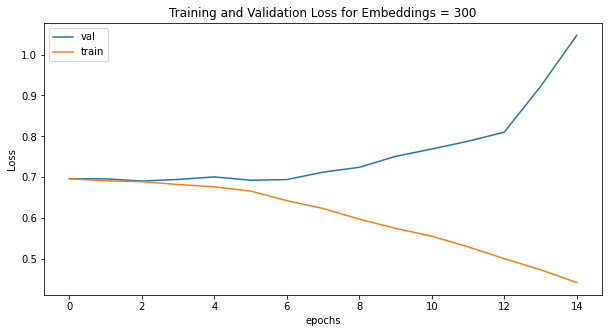

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_pop_10.jpg")
plt.show()

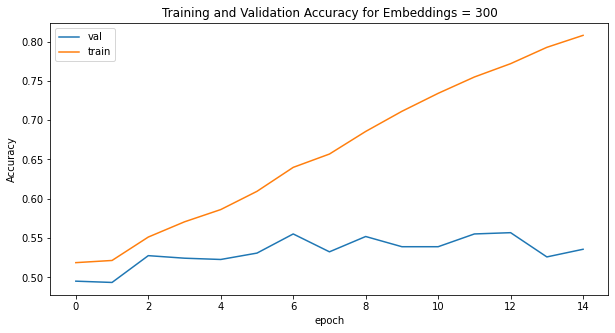

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("acc_pop_10.jpg")
plt.show()